#

# Step 1.1: Install Necessary Libraries

In [1]:
# Install gdown to handle Google Drive links
!pip install gdown
# Install the efficientnet library
!pip install -U efficientnet
# Ensure keras and its dependencies are available (use -q for quiet output)
!pip install -q keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.6 MB/s eta 0:00:00


#

# 2. 📂 Dataset Download and Extraction
The dataset is hosted on Google Drive and needs to be downloaded, unzipped, and organized in the Colab environment.

Step 2.1: Define Variables and Download Logic
The original code uses a specific Google Drive link for the compressed dataset. We'll use the provided code to download and extract it.

In [2]:
import gdown
import zipfile
import os

# Replace 'YOUR_FOLDER_LINK' with the link you copied from Google Drive
folder_link = 'https://drive.google.com/file/d/1jjCfYXV7szI4JNbOJZAh8I-yVRnoJDUY/view?usp=sharing'
output_zip = 'dataset.zip'
output_dir = 'autism_dataset'

# Construct the download link
file_id = folder_link.split('/')[-2]
download_url = f'https://drive.google.com/uc?id={file_id}'

# Download the folder as a zip file
gdown.download(download_url, output_zip, quiet=False)

# Unzip the file
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

# Remove the zip file to save disk space
os.remove(output_zip)

print(f"Dataset extracted to '{output_dir}'")

Downloading...
From (original): https://drive.google.com/uc?id=1jjCfYXV7szI4JNbOJZAh8I-yVRnoJDUY
From (redirected): https://drive.google.com/uc?id=1jjCfYXV7szI4JNbOJZAh8I-yVRnoJDUY&confirm=t&uuid=410e0867-daba-4b82-a52a-2a3db529741a
To: /content/dataset.zip
100%|██████████| 240M/240M [00:07<00:00, 32.5MB/s]


Dataset extracted to 'autism_dataset'


#

# 3. 🖼️ Data Exploration and DataFrame Creation
Now that the data is extracted, we need to map the image files to their correct labels (Autistic/Non-Autistic) and organize them into Pandas DataFrames.

Step 3.1: Define File Paths
Set the base directory and the paths for the training, validation, and test subsets.

In [3]:
import os

base_dir = '/content/autism_dataset/AutismDataset/'
train_path = os.path.join(base_dir, 'train/')
valid_path = os.path.join(base_dir, 'valid/')
test_path = os.path.join(base_dir, 'test/')

paths = {'train': train_path, 'valid': valid_path, 'test': test_path}

# --- Sanity Check (Code from document) ---
# This check verifies that the directories exist and are not empty
for key, value in paths.items():
    if not os.path.exists(value):
        print(f"ERROR: The {key} directory was not found at path: {value}")
        print("Please check the contents of your zip file.")
        # sys.exit() # Commented out for smoother Colab run
    if not os.listdir(value):
        print(f"ERROR: The {key} directory at '{value}' is empty.")
        # sys.exit() # Commented out for smoother Colab run
print("All directories (train, valid, test) found and are not empty. Proceeding...")

All directories (train, valid, test) found and are not empty. Proceeding...


#

# Step 3.2: Define Helper Functions for DataFrames
The script uses two different methods to get labels:

From Filenames: Used for train and test data (e.g., Autistic.1.jpg).

From Subdirectories: Used for valid data (e.g., images are in valid/Autistic/ or valid/Non_Autistic/).

In [4]:
import pandas as pd
# Function for train and test sets (labels in filename)
def create_df_from_filenames(folder_path):
    file_paths = []
    labels = []
    for filename in sorted(os.listdir(folder_path)):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Assumes the label is the first part of the filename (e.g., 'Autistic' from 'Autistic.1.jpg')
            label = filename.split('.')[0]
            file_paths.append(os.path.join(folder_path, filename))
            labels.append(label)
    return pd.DataFrame({'file_path': file_paths, 'label_name': labels})

# Function for validation set (labels are subdirectories)
def create_df_from_subdirs(folder_path):
    file_paths = []
    labels = []
    for class_name in sorted(os.listdir(folder_path)):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            for filename in sorted(os.listdir(class_path)):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_paths.append(os.path.join(class_path, filename))
                    labels.append(class_name)
    return pd.DataFrame({'file_path': file_paths, 'label_name': labels})

#

# Step 3.3: Apply Functions and Create DataFrames

In [5]:
# Apply the correct function to each directory
train_df = create_df_from_filenames(train_path)
validate_df = create_df_from_subdirs(valid_path)
test_df = create_df_from_filenames(test_path)

# Final check to ensure no dataframe is empty
if train_df.empty or validate_df.empty or test_df.empty:
    print("\nERROR: One or more dataframes are empty. This means no images were found.")
    # sys.exit() # Commented out for smoother Colab run

print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(validate_df)}")
print(f"Test samples: {len(test_df)}")

print("\nExample from validation data (should have subdirectory paths):")
print(validate_df.head())


Training samples: 2540
Validation samples: 100
Test samples: 300

Example from validation data (should have subdirectory paths):
                                           file_path label_name
0  /content/autism_dataset/AutismDataset/valid/Au...   Autistic
1  /content/autism_dataset/AutismDataset/valid/Au...   Autistic
2  /content/autism_dataset/AutismDataset/valid/Au...   Autistic
3  /content/autism_dataset/AutismDataset/valid/Au...   Autistic
4  /content/autism_dataset/AutismDataset/valid/Au...   Autistic


#

# 4. 🧠 EfficientNetB0 Model Setup and Training
We will now move to the main machine learning pipeline, starting with the EfficientNetB0 model.

Step 4.1: Import ML Libraries and Define Variables
Import all necessary Keras/TensorFlow components and define global parameters like image size and batch size.

In [6]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation, RandomBrightness
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import AUC, Precision, Recall
from keras.optimizers import Adam
from keras.applications import efficientnet # For preprocessing function

# --- GLOBAL VARIABLES ---
MODEL_SAVE_PATH = '/content/autism_efficientnet.keras'
image_size = 224
batch_size = 20
AUTOTUNE = tf.data.AUTOTUNE

class_names = sorted(train_df['label_name'].unique())
num_classes = len(class_names)
print(f"Image Size: {image_size}, Batch Size: {batch_size}, Classes: {class_names}")

Image Size: 224, Batch Size: 20, Classes: ['Autistic', 'Non_Autistic']


#

# Step 4.2: Define Data Augmentation and Preprocessing Pipeline
We define the advanced augmentation pipeline and the function to configure a tf.data.Dataset for EfficientNetB0.

In [7]:
# Create a lookup table for labels (e.g., 'Autistic' -> 0, 'Non_Autistic' -> 1)
keys = tf.constant(class_names, dtype=tf.string)
values = tf.constant(range(num_classes), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(keys, values)
label_to_index_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

# --- Advanced Data Augmentation Pipeline ---
print("\n--- Defining new, advanced data augmentation pipeline ---")
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomTranslation(height_factor=0.1, width_factor=0.1), # NEW
    RandomBrightness(factor=0.1) # NEW
], name="data_augmentation_advanced")

# --- Image Processing Function ---
def process_image(filepath, label):
    label_index = label_to_index_table.lookup(label)
    label_one_hot = tf.one_hot(label_index, num_classes)

    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    return image, label_one_hot

# --- Dataset Configuration Function for EfficientNet ---
def configure_dataset_for_efficientnet(df, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((df['file_path'].values, df['label_name'].values))
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE) # Map image reading/resizing/labeling

    if shuffle:
      ds = ds.shuffle(buffer_size=len(df))

    ds = ds.batch(batch_size) # Batch before augmentation

    if augment:
        # Apply the data augmentation layer (only during training)
      ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # Use the EfficientNet-specific preprocessing function
    ds = ds.map(lambda x, y: (efficientnet.preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)


--- Defining new, advanced data augmentation pipeline ---


#

# Step 4.3: Create Data Pipelines
Use the configuration function to create the final, preprocessed and augmented datasets for training, validation, and testing.

In [8]:
print("--- Creating EfficientNet-specific data pipelines...---")
train_set_effnet = configure_dataset_for_efficientnet(train_df, shuffle=True, augment=True)
val_set_effnet = configure_dataset_for_efficientnet(validate_df)
test_set_effnet = configure_dataset_for_efficientnet(test_df)
print("Pipelines created.")

--- Creating EfficientNet-specific data pipelines...---
Pipelines created.


#

# Step 4.4: Build and Compile the EfficientNetB0 Model
This step loads the pre-trained EfficientNetB0 model (Transfer Learning), adds a new classification head, and compiles it with an Adam optimizer and standard metrics.

In [9]:
from keras.applications import EfficientNetB0

# Load the EfficientNetB0 model, excluding the top (classification) layer,
# and initialize weights from the Imagenet dataset.
base_model_effnet = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))

# Freeze the weights of the base model so they are not changed during initial training.
base_model_effnet.trainable = False

# Build the Sequential model: Base Model + New Classification Head
model_effnet = Sequential([
    base_model_effnet,
    GlobalAveragePooling2D(), # Reduces the feature maps to a single vector
    Dense(128, activation='relu'),
    Dropout(0.5), # Dropout for regularization
    Dense(num_classes, activation='softmax') # Output layer for classification
])

# Compile the model
model_effnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

model_effnet.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

#

# Step 4.5: Train the EfficientNetB0 Model
This step defines the training parameters and callbacks (Early Stopping and Model Checkpoint) to train the model.

In [10]:
# --- Training Logic ---
if os.path.exists(MODEL_SAVE_PATH):
    print(f"\n--- Found pre-trained model at {MODEL_SAVE_PATH}. Loading weights. ---")
    model_effnet.load_weights(MODEL_SAVE_PATH)
    history_effnet = None
else:
    print(f"\n--- No pre-trained model found. Starting training... ---")
    epochs = 30

    # Callbacks to stop training early and save the best model
    callbacks_effnet = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)
    ]

    # Start training the model
    history_effnet = model_effnet.fit(
        train_set_effnet,
        validation_data=val_set_effnet,
        callbacks=callbacks_effnet,
        epochs=epochs,
    )
    print(f"\nTraining complete. Best model saved to: {MODEL_SAVE_PATH}")
    model_effnet.load_weights(MODEL_SAVE_PATH) # Load the best version saved by the checkpoint

# Note: The original script was interrupted by a KeyboardInterrupt (line 212)
# so your training may also take some time.


--- No pre-trained model found. Starting training... ---
Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 233s 2s/step - accuracy: 0.6970 - auc: 0.7554 - loss: 0.5962 - precision: 0.6970 - recall: 0.6970 - val_accuracy: 0.7500 - val_auc: 0.8668 - val_loss: 0.4493 - val_precision: 0.7500 - val_recall: 0.7500
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.7517 - auc: 0.8441 - loss: 0.4864 - precision: 0.7517 - recall: 0.7517 - val_accuracy: 0.7300 - val_auc: 0.8471 - val_loss: 0.4762 - val_precision: 0.7300 - val_recall: 0.7300
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.7770 - auc: 0.8542 - loss: 0.4758 - precision: 0.7770 - recall: 0.7770 - val_accuracy: 0.7700 - val_auc: 0.8431 - val_loss: 0.4788 - val_precision: 0.7700 - val_recall: 0.7700
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.7673 - auc: 0.8558 - loss: 0.4701 - precision: 0.7673 - recall: 0.7673 - val_accuracy: 0.7800 - val_auc: 0.8485 - val_loss: 0.4968 - val_precision

# 5. 📊 EfficientNetB0 Evaluation and Visualization
After training, the model must be evaluated on the unseen test set, and a classification report and confusion matrix should be generated.

Step 5.1: Evaluate and Plot History
Evaluate the final model and plot the loss/accuracy history if training was completed.


--- Final Evaluation of EfficientNet on Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.8184 - auc: 0.9062 - loss: 0.3898 - precision: 0.8184 - recall: 0.8184
Test Loss: 0.3973
Test Accuracy: 0.8233

Plotting training history...


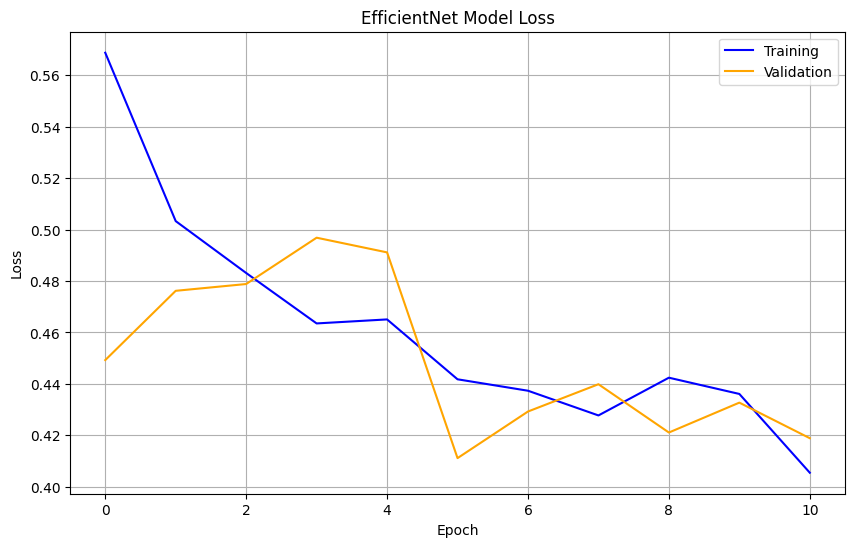

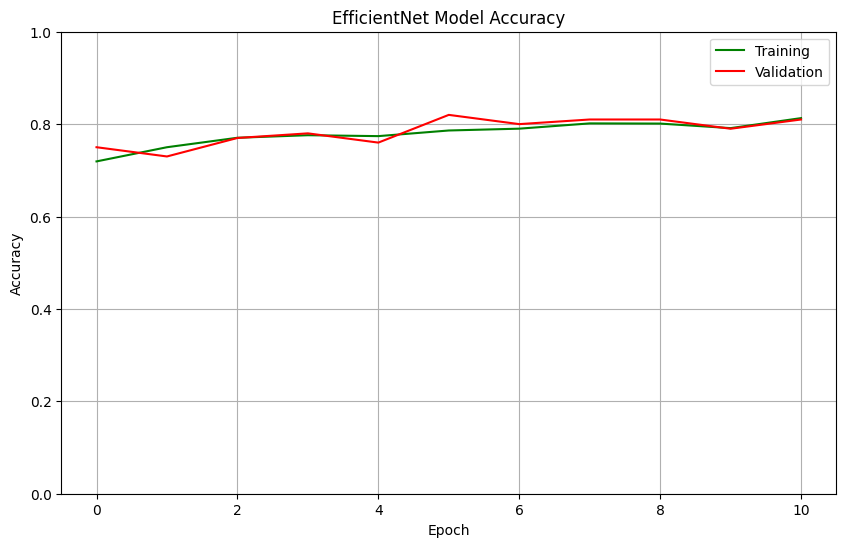

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

print("\n--- Final Evaluation of EfficientNet on Test Set ---")
# The evaluate function returns the loss and all the metrics defined during compilation.
evaluation_metrics = model_effnet.evaluate(test_set_effnet)
print(f"Test Loss: {evaluation_metrics[0]:.4f}")
print(f"Test Accuracy: {evaluation_metrics[1]:.4f}")

if history_effnet is not None:
    print("\nPlotting training history...")
    history_df = pd.DataFrame(history_effnet.history)
    epochs_ran = len(history_df)

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['loss'], color='blue', label='Training')
    plt.plot(history_df['val_loss'], color='orange', label='Validation')
    plt.title('EfficientNet Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['accuracy'], color='green', label='Training')
    plt.plot(history_df['val_accuracy'], color='red', label='Validation')
    plt.title('EfficientNet Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
else:
    print("\nSkipped plotting history because the model was loaded from disk.")

# Step 5.2: Generate Confusion Matrix and Classification Report
Calculate the predictions and generate standard performance metrics using sklearn.

15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


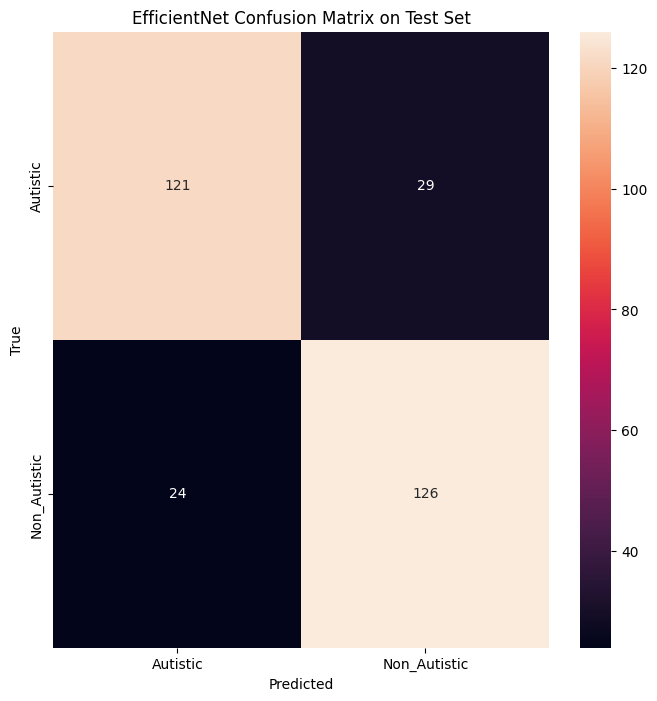


EfficientNet Classification Report on Test Set:
              precision    recall  f1-score   support

    Autistic       0.83      0.81      0.82       150
Non_Autistic       0.81      0.84      0.83       150

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Prepare variables for scikit-learn reports ---
class_names = sorted(train_df['label_name'].unique())
label_to_index = {name: i for i, name in enumerate(class_names)}
y_true_indices = test_df['label_name'].map(label_to_index).values

# Generate predictions
y_pred_probas_effnet = model_effnet.predict(test_set_effnet)
y_pred_classes_effnet = np.argmax(y_pred_probas_effnet, axis=1)

# --- Confusion Matrix ---
conf_mat_effnet = confusion_matrix(y_true_indices, y_pred_classes_effnet)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat_effnet, annot=True, ax=ax, fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.set_title('EfficientNet Confusion Matrix on Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

# --- Classification Report ---
print("\nEfficientNet Classification Report on Test Set:")
print(classification_report(y_true_indices, y_pred_classes_effnet, target_names=class_names))

# 6. 🧠 ResNet50 Model Setup and Training (Comparison)
Next, we repeat the process for the ResNet50 model to compare its performance. Note that the preprocessing step is different for ResNet models.

Step 6.1: ResNet-Specific Preprocessing Function
We need a separate function because ResNet uses a different preprocessing step

In [13]:
from keras.applications import ResNet50
from keras.applications import resnet # For the preprocessing function

# Define a new save path for the ResNet50 model
MODEL_SAVE_PATH_RESNET = '/content/autism_resnet50_final.keras'

# --- Dataset Configuration Function for ResNet50 ---
def configure_dataset_for_resnet(df, shuffle=False, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((df['file_path'].values, df['label_name'].values))
    ds = ds.map(process_image, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))

    ds = ds.batch(batch_size)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)

    # The key change: Use the ResNet preprocessing function
    ds = ds.map(lambda x, y: (resnet.preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

# Step 6.2: Create ResNet-Specific Data Pipelines
Apply the new configuration function to the datasets.

In [14]:
print("--- Creating ResNet50-specific data pipelines... ---")
train_set_resnet = configure_dataset_for_resnet(train_df, shuffle=True, augment=True)
val_set_resnet = configure_dataset_for_resnet(validate_df)
test_set_resnet = configure_dataset_for_resnet(test_df)
print("Pipelines created.")

--- Creating ResNet50-specific data pipelines... ---
Pipelines created.


# Step 6.3: Build and Compile the ResNet50 Model
This builds the ResNet50 model using the same architecture as EfficientNetB0 (frozen base, custom head).

In [15]:
# Load the ResNet50 model, excluding the top layer
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(image_size, image_size, 3))

# Freeze the base model
base_model_resnet.trainable = False

# Build the Sequential model: Base Model + New Classification Head
model_resnet = Sequential([
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_resnet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Step 6.4: Train the ResNet50 Model
Train the ResNet50 model using the same training schedule and callbacks.

In [16]:
# --- Training Logic ---
if os.path.exists(MODEL_SAVE_PATH_RESNET):
    print(f"\n--- Found pre-trained model at '{MODEL_SAVE_PATH_RESNET}'. Loading weights. ---")
    model_resnet.load_weights(MODEL_SAVE_PATH_RESNET)
    history_resnet = None
else:
    print(f"\n--- No pre-trained model found. Starting training... ---")
    epochs = 30

    # Callbacks
    callbacks_resnet = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(MODEL_SAVE_PATH_RESNET, monitor='val_loss', save_best_only=True)
    ]

    # Start training the model
    history_resnet = model_resnet.fit(
        train_set_resnet,
        validation_data=val_set_resnet,
        epochs=epochs,
        callbacks=callbacks_resnet
    )
    print(f"\nTraining complete. Best model saved to: {MODEL_SAVE_PATH_RESNET}")
    model_resnet.load_weights(MODEL_SAVE_PATH_RESNET) # Load the best version saved by the checkpoint


--- No pre-trained model found. Starting training... ---
Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 475s 4s/step - accuracy: 0.6052 - auc: 0.6475 - loss: 0.8302 - precision: 0.6052 - recall: 0.6052 - val_accuracy: 0.7400 - val_auc: 0.8280 - val_loss: 0.5127 - val_precision: 0.7400 - val_recall: 0.7400
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 469s 4s/step - accuracy: 0.7459 - auc: 0.8296 - loss: 0.5065 - precision: 0.7459 - recall: 0.7459 - val_accuracy: 0.7000 - val_auc: 0.7839 - val_loss: 0.5627 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 470s 4s/step - accuracy: 0.7301 - auc: 0.8129 - loss: 0.5219 - precision: 0.7301 - recall: 0.7301 - val_accuracy: 0.7700 - val_auc: 0.8470 - val_loss: 0.4730 - val_precision: 0.7700 - val_recall: 0.7700
Epoch 4/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 456s 4s/step - accuracy: 0.7537 - auc: 0.8432 - loss: 0.4871 - precision: 0.7537 - recall: 0.7537 - val_accuracy: 0.8100 - val_auc: 0.8875 - val_loss: 0.4205 - val_precision

# 7. 📊 ResNet50 Evaluation and Visualization
Evaluate the ResNet50 model and generate the final reports for comparison.

Step 7.1: Evaluate and Plot History


--- Final Evaluation of ResNet50 on Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.9153 - auc: 0.9621 - loss: 0.2450 - precision: 0.9153 - recall: 0.9153
Test Loss: 0.3967
Test Accuracy: 0.8367

Plotting training history...


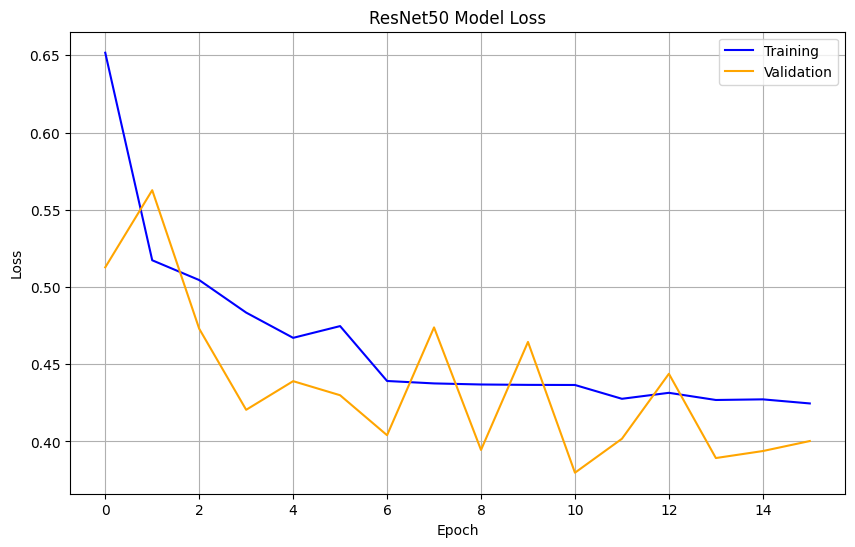

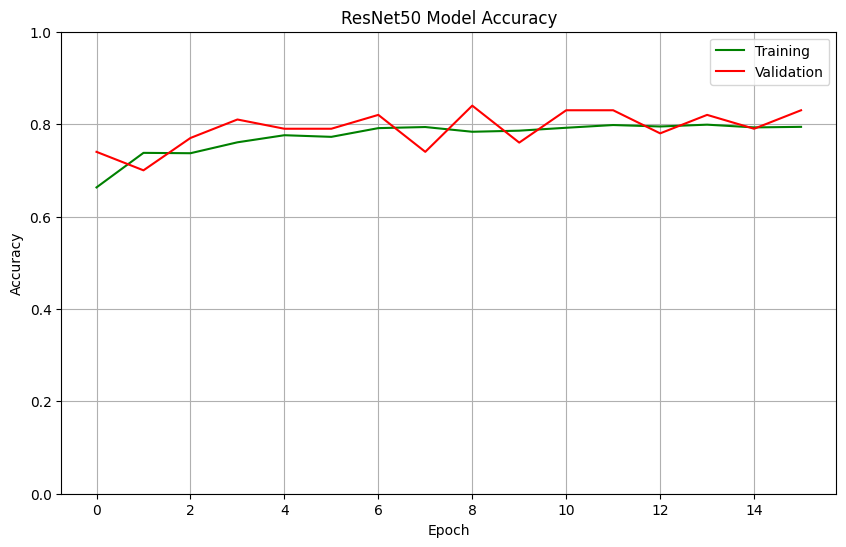

In [17]:
print("\n--- Final Evaluation of ResNet50 on Test Set ---")
evaluation_metrics_resnet = model_resnet.evaluate(test_set_resnet)
print(f"Test Loss: {evaluation_metrics_resnet[0]:.4f}")
print(f"Test Accuracy: {evaluation_metrics_resnet[1]:.4f}")

if history_resnet is not None:
    print("\nPlotting training history...")
    history_df_resnet = pd.DataFrame(history_resnet.history)

    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history_df_resnet['loss'], color='blue', label='Training')
    plt.plot(history_df_resnet['val_loss'], color='orange', label='Validation')
    plt.title('ResNet50 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history_df_resnet['accuracy'], color='green', label='Training')
    plt.plot(history_df_resnet['val_accuracy'], color='red', label='Validation')
    plt.title('ResNet50 Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
else:
    print("\nSkipped plotting history because the model was loaded from disk.")

# Step 7.2: Generate Confusion Matrix and Classification Report

15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step


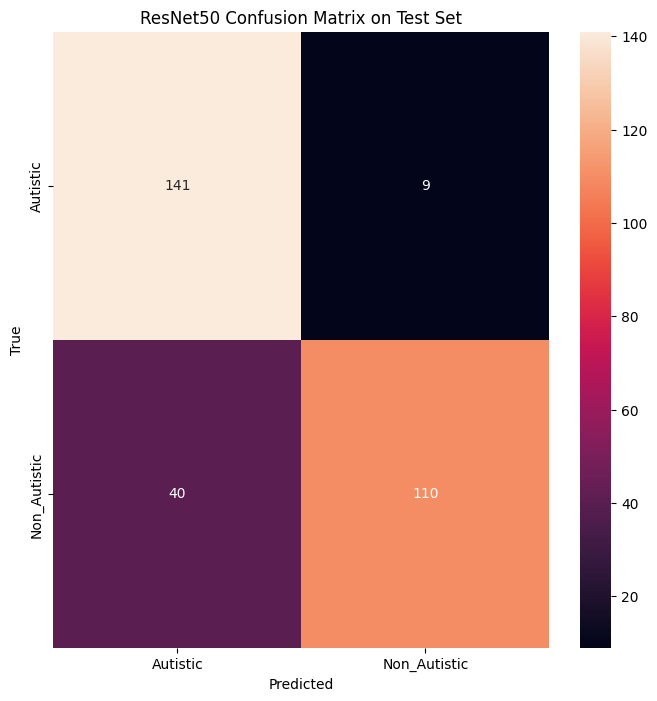


ResNet50 Classification Report on Test Set:
              precision    recall  f1-score   support

    Autistic       0.78      0.94      0.85       150
Non_Autistic       0.92      0.73      0.82       150

    accuracy                           0.84       300
   macro avg       0.85      0.84      0.83       300
weighted avg       0.85      0.84      0.83       300



In [18]:
# Generate predictions
y_pred_probas_resnet = model_resnet.predict(test_set_resnet)
y_pred_classes_resnet = np.argmax(y_pred_probas_resnet, axis=1)

# --- Confusion Matrix ---
conf_mat_resnet = confusion_matrix(y_true_indices, y_pred_classes_resnet)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat_resnet, annot=True, ax=ax, fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.set_title('ResNet50 Confusion Matrix on Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

# --- Classification Report ---
print("\nResNet50 Classification Report on Test Set:")
print(classification_report(y_true_indices, y_pred_classes_resnet, target_names=class_names))

# 8. 🎯 Phase 2: ResNet50 Fine-Tuning
We will now modify the ResNet50 model trained in Phase 1 by "unfreezing" a few of its top convolutional blocks and training the entire (unfrozen) portion with a very low learning rate.

Step 8.1: Unfreeze the Base Model (Partial Unfreezing)
We need to make the weights of the ResNet50 base model trainable again, but typically only the layers closer to the output are unfrozen.

In [19]:
# Unfreeze the base model
print("Unfreezing the base model...")
model_resnet.layers[0].trainable = True

print(f"Total layers in ResNet50 base model: {len(model_resnet.layers[0].layers)}")

Unfreezing the base model...
Total layers in ResNet50 base model: 175


# Step 8.2: Select and Freeze Initial Layers
In the original script, we only want to fine-tune the later blocks (around the last 30-50 layers). We iterate through all layers and freeze the first 140 layers to keep the very early feature extraction layers intact.

In [20]:
# Freeze the layers at the beginning (first 140 layers, as per the original script)
# to preserve low-level features (edges, textures).
print("Freezing the first 140 layers of the ResNet50 base model...")
for layer in model_resnet.layers[0].layers[:140]:
    layer.trainable = False

# Check how many layers are now trainable
trainable_count = sum([1 for layer in model_resnet.layers[0].layers if layer.trainable])
print(f"Number of layers now trainable in the base model: {trainable_count}")

Freezing the first 140 layers of the ResNet50 base model...
Number of layers now trainable in the base model: 35


# 9. 🚀 Fine-Tuning Compilation and TrainingSince we changed which parts of the model are trainable, we must recompile the model. Crucially, we use a much smaller learning rate to ensure the weights are only adjusted slightly (fine-tuned) and don't overwrite the general features drastically.Step 9.1: Recompile the Model with Low Learning RateWe use a Learning Rate of $10^{-5}$ (0.00001).

In [21]:
from keras.optimizers import Adam
from keras.metrics import AUC, Precision, Recall

FINE_TUNE_LR = 0.00001
FINE_TUNE_SAVE_PATH = '/content/autism_resnet50_finetuned.keras'

print(f"Recompiling model with new (unfrozen) layers and a learning rate of {FINE_TUNE_LR}...")

model_resnet.compile(
    optimizer=Adam(learning_rate=FINE_TUNE_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

print("Model recompiled successfully.")

Recompiling model with new (unfrozen) layers and a learning rate of 1e-05...
Model recompiled successfully.


# Step 9.2: Train for Fine-Tuning
We run the training again for a few epochs (the script uses 10 epochs) using the same data and monitoring the same validation metrics.

In [22]:
# --- Fine-Tuning Training Logic ---
print(f"\n--- Starting Phase 2: Fine-Tuning for ResNet50 ---")
epochs_fine_tune = 10

# Callbacks for fine-tuning
callbacks_fine_tune = [
    # Use Early Stopping, potentially with a higher patience, but the script uses the same 5
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # Save the best model from the fine-tuning phase
    ModelCheckpoint(FINE_TUNE_SAVE_PATH, monitor='val_loss', save_best_only=True)
]

# Note: The original script records the history starting from the end of Phase 1.
# To replicate this, we will use the `model_resnet` instance that has the Phase 1 weights loaded.

history_fine_tune = model_resnet.fit(
    train_set_resnet,
    validation_data=val_set_resnet,
    epochs=epochs_fine_tune,
    callbacks=callbacks_fine_tune
)
print(f"\nFine-Tuning complete. Best model saved to: {FINE_TUNE_SAVE_PATH}")
model_resnet.load_weights(FINE_TUNE_SAVE_PATH) # Load the best version saved by the checkpoint


--- Starting Phase 2: Fine-Tuning for ResNet50 ---
Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 776s 6s/step - accuracy: 0.5758 - auc: 0.6802 - loss: 0.9811 - precision: 0.5758 - recall: 0.5758 - val_accuracy: 0.7400 - val_auc: 0.8644 - val_loss: 0.4696 - val_precision: 0.7400 - val_recall: 0.7400
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 737s 6s/step - accuracy: 0.7660 - auc: 0.8446 - loss: 0.5046 - precision: 0.7660 - recall: 0.7660 - val_accuracy: 0.7700 - val_auc: 0.8682 - val_loss: 0.4534 - val_precision: 0.7700 - val_recall: 0.7700
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 737s 6s/step - accuracy: 0.8108 - auc: 0.8911 - loss: 0.4134 - precision: 0.8108 - recall: 0.8108 - val_accuracy: 0.7600 - val_auc: 0.8876 - val_loss: 0.4183 - val_precision: 0.7600 - val_recall: 0.7600
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 736s 6s/step - accuracy: 0.8163 - auc: 0.9069 - loss: 0.3867 - precision: 0.8163 - recall: 0.8163 - val_accuracy: 0.8000 - val_auc: 0.8996 - val_loss: 0.3976 - val_precision: 0.80

# 10. 📊 Fine-Tuning Evaluation
Finally, we evaluate the fine-tuned model's performance and plot the combined training history.

Step 10.1: Evaluate and Plot History
We evaluate the final fine-tuned model on the test set. If you successfully captured both Phase 1 (history_resnet) and Phase 2 (history_fine_tune) histories, we can combine them for a full plot.


--- Final Evaluation of Fine-Tuned ResNet50 on Test Set ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9125 - auc: 0.9656 - loss: 0.2343 - precision: 0.9125 - recall: 0.9125
Fine-Tuned Test Loss: 0.3517
Fine-Tuned Test Accuracy: 0.8533


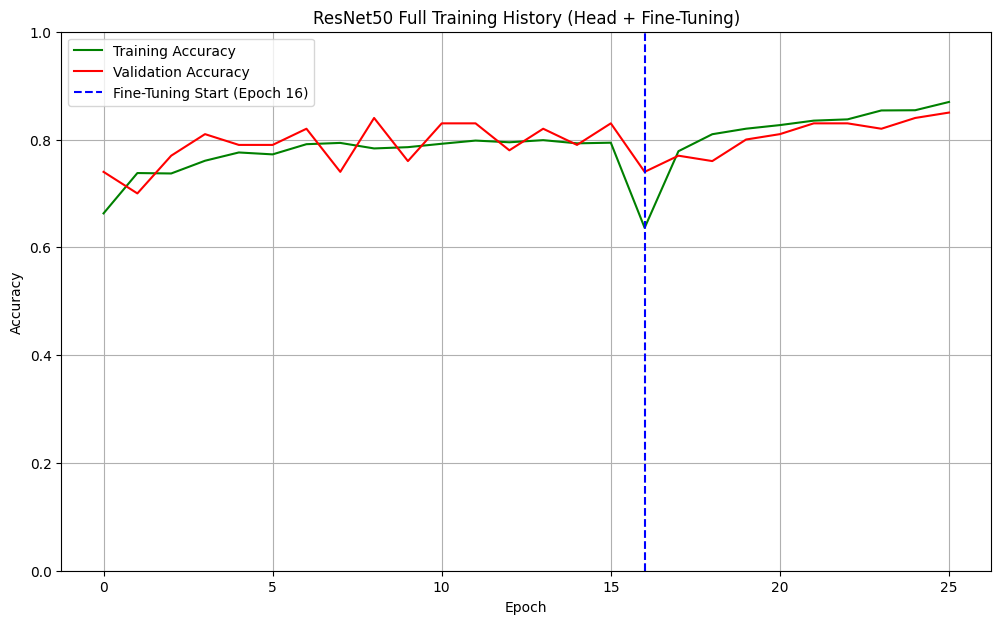

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("\n--- Final Evaluation of Fine-Tuned ResNet50 on Test Set ---")
evaluation_metrics_finetune = model_resnet.evaluate(test_set_resnet)
print(f"Fine-Tuned Test Loss: {evaluation_metrics_finetune[0]:.4f}")
print(f"Fine-Tuned Test Accuracy: {evaluation_metrics_finetune[1]:.4f}")

# --- Combined History Plotting ---
if 'history_resnet' in locals() and history_resnet is not None:
    # Combine the history from Phase 1 and Phase 2
    history_1_df = pd.DataFrame(history_resnet.history)
    history_2_df = pd.DataFrame(history_fine_tune.history)

    # Reset indices so epochs align
    history_2_df.index = history_2_df.index + len(history_1_df)

    # Concatenate the histories
    full_history_df = pd.concat([history_1_df, history_2_df])

    epochs_ran = len(full_history_df)
    finetune_start_epoch = len(history_1_df)

    # Plot Accuracy
    plt.figure(figsize=(12, 7))
    plt.plot(full_history_df['accuracy'], color='green', label='Training Accuracy')
    plt.plot(full_history_df['val_accuracy'], color='red', label='Validation Accuracy')

    # Mark the start of fine-tuning
    plt.axvline(x=finetune_start_epoch, color='blue', linestyle='--', label=f'Fine-Tuning Start (Epoch {finetune_start_epoch})')

    plt.title('ResNet50 Full Training History (Head + Fine-Tuning)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

else:
    print("\nSkipped plotting combined history because Phase 1 history was not available.")

# Step 10.2: Generate Final Classification Report
Generate the final confusion matrix and classification report for the fine-tuned ResNet50 model.

15/15 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step


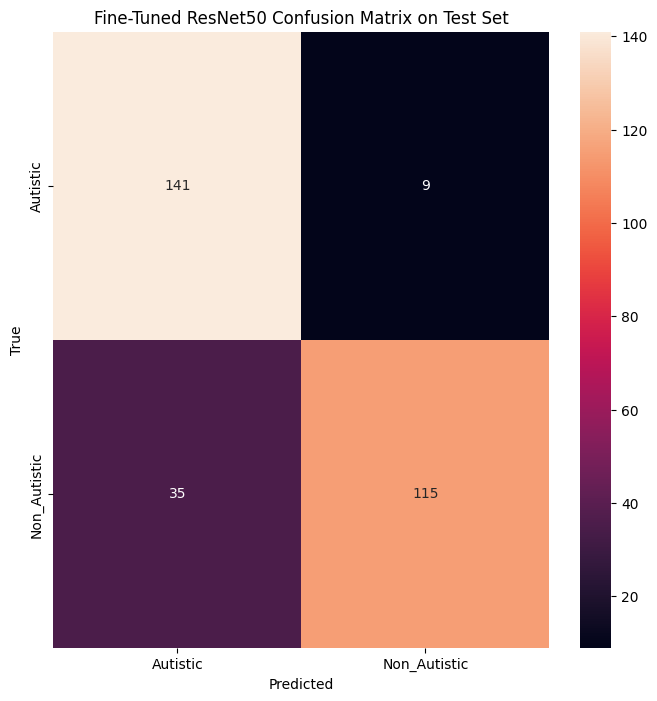


Fine-Tuned ResNet50 Classification Report on Test Set:
              precision    recall  f1-score   support

    Autistic       0.80      0.94      0.87       150
Non_Autistic       0.93      0.77      0.84       150

    accuracy                           0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



In [24]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Prepare variables (defined earlier in the notebook, but repeated here for completeness)
class_names = sorted(train_df['label_name'].unique())
label_to_index = {name: i for i, name in enumerate(class_names)}
y_true_indices = test_df['label_name'].map(label_to_index).values

# Generate predictions from the fine-tuned model
y_pred_probas_resnet_finetune = model_resnet.predict(test_set_resnet)
y_pred_classes_resnet_finetune = np.argmax(y_pred_probas_resnet_finetune, axis=1)

# --- Confusion Matrix ---
conf_mat_resnet_finetune = confusion_matrix(y_true_indices, y_pred_classes_resnet_finetune)

fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(conf_mat_resnet_finetune, annot=True, ax=ax, fmt='d', xticklabels=class_names, yticklabels=class_names)
ax.set_title('Fine-Tuned ResNet50 Confusion Matrix on Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

# --- Classification Report ---
print("\nFine-Tuned ResNet50 Classification Report on Test Set:")
print(classification_report(y_true_indices, y_pred_classes_resnet_finetune, target_names=class_names))

In [25]:
!pip install -q streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 29.1 MB/s eta 0:00:00


In [29]:
# Install Streamlit, a dependency for image handling, and localtunnel for Colab access
!pip install streamlit
!pip install opencv-python
!pip install localtunnel
# Also install scikit-learn for completeness, as it's often useful
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement localtunnel (from versions: none)
ERROR: No matching distribution found for localtunnel
